## WAVE data retrieval
### thanks to Copernicus

In [2]:
pip install copernicusmarine

     ---------------------------------------- 83.4/83.4 kB 2.4 MB/s eta 0:00:00
     -------------------------------------- 819.3/819.3 kB 5.2 MB/s eta 0:00:00
     ---------------------------------------- 2.3/2.3 MB 6.7 MB/s eta 0:00:00
     ------------------------------------- 181.6/181.6 kB 10.7 MB/s eta 0:00:00
     ---------------------------------------- 78.3/78.3 kB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 2.3 MB/s eta 0:00:00
     -------------------------------------- 365.2/365.2 kB 7.6 MB/s eta 0:00:00
     ------------------------------------- 207.5/207.5 kB 13.1 MB/s eta 0:00:00
     -------------------------------------- 139.3/139.3 kB 8.1 MB/s eta 0:00:00
     ---------------------------------------- 6.6/6.6 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 50.4/50.4 kB ? eta 0:00:00
     --------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.41 requires requests_mock, which is not installed.
conda-repo-cli 1.0.41 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.41 requires nbformat==5.4.0, but you have nbformat 5.7.0 which is incompatible.


In [2]:
# Import modules
import copernicusmarine

# Define parameters to run the extraction
dataset_id = "cmems_mod_glo_wav_my_0.2_PT3H-i"  # Ensure the dataset ID is correct

# Load dataframe
request_dataframe = copernicusmarine.read_dataframe(
    dataset_id=dataset_id,
    minimum_longitude=-42.56,  # Corrected for 42.68°W
    maximum_longitude=-42.56,  # Assuming a single point; expand as needed
    minimum_latitude=59.46,    # Corrected for 59.48°N
    maximum_latitude=59.46,    # Assuming a single point; expand as needed
    # Update the variable names based on the dataset documentation
    variables=[
        "sea_surface_primary_swell_wave_mean_period",  # Example variable name for sea_surface_wind_wave_significant_height
        "sea_surface_primary_swell_wave_significant_height",  # Example variable name for sea_surface_wind_wave_mean_period
        # Add additional variables as needed for primary/secondary swells
    ],
    start_datetime="2015-01-01T00:00:00",  # Set the correct start date
    end_datetime="2019-12-31T23:59:59",    # Set the correct end date
    # Include depth if the dataset supports it and is relevant for your analysis
    # minimum_depth=0,
    # maximum_depth=6
)

request_dataframe


Fetching catalog: 100%|██████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.48s/it]


INFO - 2024-03-12T10:27:09Z - Dataset version was not specified, the latest one was selected: "202112"
INFO - 2024-03-12T10:27:09Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-03-12T10:27:12Z - Service was not specified, the default one was selected: "arco-time-series"
username: gillesooms@outlook.com
password: ········


,,,VTM01_SW1,VHM0_SW1
time,latitude,longitude,,
2015-01-01 00:00:00,59.400002,-42.600006,11.130000,2.05
2015-01-01 03:00:00,59.400002,-42.600006,10.990000,1.89
2015-01-01 06:00:00,59.400002,-42.600006,10.719999,1.77
2015-01-01 09:00:00,59.400002,-42.600006,11.670000,1.34
2015-01-01 12:00:00,59.400002,-42.600006,8.710000,2.45
...,...,...,...,...
2019-12-31 09:00:00,59.400002,-42.600006,10.170000,2.81
2019-12-31 12:00:00,59.400002,-42.600006,10.179999,2.68
2019-12-31 15:00:00,59.400002,-42.600006,10.540000,2.52


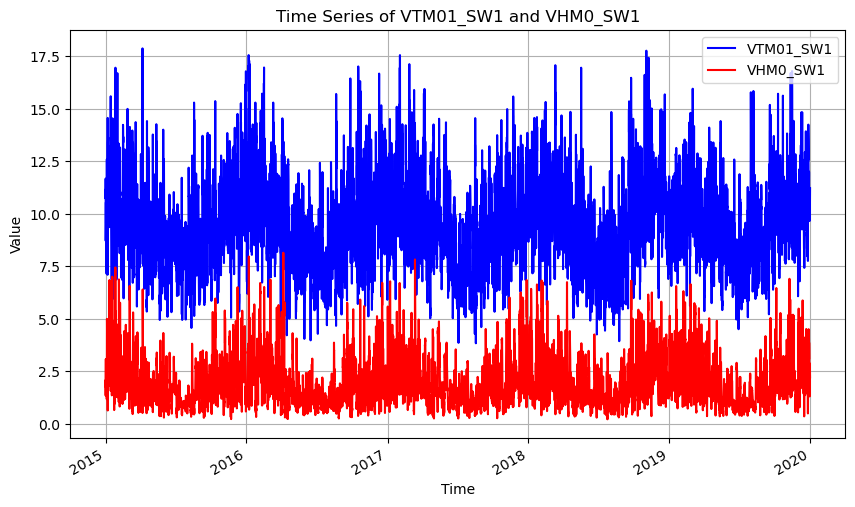

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Reset the index to make all current index columns into regular columns
df_reset = request_dataframe.reset_index()

# Assuming the datetime column is named 'time' after resetting the index. If it's named differently, adjust accordingly.
# Set this column as the new index
df_reset.set_index('time', inplace=True)

# Now, ensure the index is in datetime format
df_reset.index = pd.to_datetime(df_reset.index)

# Plotting
plt.figure(figsize=(10, 6))

# Plot VTM01_SW1
plt.plot(df_reset.index, df_reset['VTM01_SW1'], label='VTM01_SW1', color='blue')

# Plot VHM0_SW1 on the same graph
plt.plot(df_reset.index, df_reset['VHM0_SW1'], label='VHM0_SW1', color='red')

# Adding some plot decorations
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series of VTM01_SW1 and VHM0_SW1')
plt.legend()
plt.grid(True)

# Adjusting x-axis date format for better readability
plt.gcf().autofmt_xdate()

plt.show()


In [9]:
request_dataframe.head()

,,,VTM01_SW1,VHM0_SW1
time,latitude,longitude,,
2015-01-01 00:00:00,59.400002,-42.600006,11.130000,2.05
2015-01-01 03:00:00,59.400002,-42.600006,10.990000,1.89
2015-01-01 06:00:00,59.400002,-42.600006,10.719999,1.77
2015-01-01 09:00:00,59.400002,-42.600006,11.670000,1.34
2015-01-01 12:00:00,59.400002,-42.600006,8.710000,2.45


In [12]:
import pandas as pd

df_reset = request_dataframe.reset_index()

# Drop the 'latitude' and 'longitude' columns
df_reset = df_reset.drop(['latitude', 'longitude'], axis=1)

# Now set 'time' as the new index
df_reset = df_reset.set_index('time')

# Now we reindex the DataFrame to have an hourly frequency, inserting NaNs for the missing times
df_hourly = df_reset.resample('H').asfreq()

# Interpolate the NaNs using cubic spline interpolation for each column you're interested in
df_hourly['VTM01_SW1'] = df_hourly['VTM01_SW1'].interpolate(method='spline', order=3)
df_hourly['VHM0_SW1'] = df_hourly['VHM0_SW1'].interpolate(method='spline', order=3)

# Show the result
print(df_hourly)

                     VTM01_SW1  VHM0_SW1
time                                    
2015-01-01 00:00:00  11.130000  2.050000
2015-01-01 01:00:00  10.565385  3.110353
2015-01-01 02:00:00  10.624785  3.109872
2015-01-01 03:00:00  10.990000  1.890000
2015-01-01 04:00:00  10.713671  3.108908
...                        ...       ...
2019-12-31 17:00:00  10.533193  3.051524
2019-12-31 18:00:00  10.820000  2.280000
2019-12-31 19:00:00  10.532286  3.052115
2019-12-31 20:00:00  10.529746  3.052409
2019-12-31 21:00:00  11.210000  2.210000

[43822 rows x 2 columns]


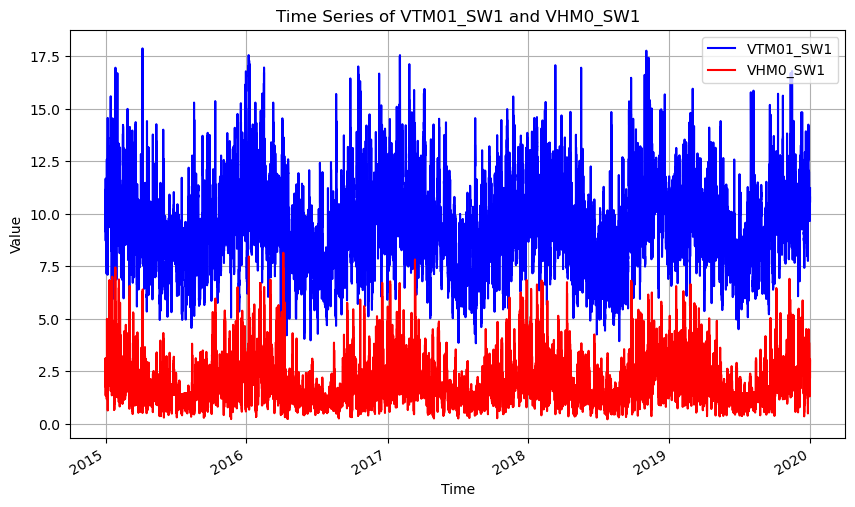

In [13]:
plt.figure(figsize=(10, 6))

# Plot VTM01_SW1
plt.plot(df_hourly.index, df_hourly['VTM01_SW1'], label='VTM01_SW1', color='blue')

# Plot VHM0_SW1 on the same graph
plt.plot(df_hourly.index, df_hourly['VHM0_SW1'], label='VHM0_SW1', color='red')

# Adding some plot decorations
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series of VTM01_SW1 and VHM0_SW1')
plt.legend()
plt.grid(True)

# Adjusting x-axis date format for better readability
plt.gcf().autofmt_xdate()

plt.show()

In [27]:
import numpy as np

# Perform the calculation and create a new DataFrame with the resulting series (in W/m)

# Constants for the calculation
rho_water = 1000  # Density of water in kg/m^3
g = 9.81  # Acceleration due to gravity in m/s^2

J_wave = (rho_water * g**2) / (64 * np.pi) * df_hourly['VTM01_SW1'] * df_hourly['VHM0_SW1']**2

J_wave = J_wave/1e9 #to convert in GW/m

result_df = pd.DataFrame(J_wave, columns=['Wave_Energy_Density'])

print(result_df)

# Save the result to a CSV file
result_df.to_csv('../../data/wave_series_goff.csv', header=False, index=False)

                     Wave_Energy_Density
time                                    
2015-01-01 00:00:00             0.000022
2015-01-01 01:00:00             0.000049
2015-01-01 02:00:00             0.000049
2015-01-01 03:00:00             0.000019
2015-01-01 04:00:00             0.000050
...                                  ...
2019-12-31 17:00:00             0.000047
2019-12-31 18:00:00             0.000027
2019-12-31 19:00:00             0.000047
2019-12-31 20:00:00             0.000047
2019-12-31 21:00:00             0.000026

[43822 rows x 1 columns]
